In [1]:
import spacy
from spacy import displacy 
from spacy.symbols import nsubj, VERB

In [33]:
import matplotlib.pyplot as plt

In [18]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("The doctors there are good.")

In [19]:
displacy.render(doc, style='dep')

In [24]:
"""
This is a more complex example on performing clustering on large scale dataset.
This examples find in a large set of sentences local communities, i.e., groups of sentences that are highly
similar. You can freely configure the threshold what is considered as similar. A high threshold will
only find extremely similar sentences, a lower threshold will find more sentence that are less similar.
A second parameter is 'min_community_size': Only communities with at least a certain number of sentences will be returned.
The method for finding the communities is extremely fast, for clustering 50k sentences it requires only 5 seconds (plus embedding comuptation).
In this example, we download a large set of questions from Quora and then find similar questions in this set.
"""
from sentence_transformers import SentenceTransformer, util
import os
import csv
import time


# Model for computing sentence embeddings. We use one trained for similar questions detection
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# We donwload the Quora Duplicate Questions Dataset (https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs)
# and find similar question in it
url = "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
dataset_path = "quora_duplicate_questions.tsv"
max_corpus_size = 50000 # We limit our corpus to only the first 50k questions


# Check if the dataset exists. If not, download and extract
# Download dataset if needed
if not os.path.exists(dataset_path):
    print("Download dataset")
    util.http_get(url, dataset_path)

# Get all unique sentences from the file
corpus_sentences = set()
with open(dataset_path, encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
    for row in reader:
        corpus_sentences.add(row['question1'])
        corpus_sentences.add(row['question2'])
        if len(corpus_sentences) >= max_corpus_size:
            break

corpus_sentences = list(corpus_sentences)
print("Encode the corpus. This might take a while")
corpus_embeddings = model.encode(corpus_sentences, batch_size=64, show_progress_bar=True, convert_to_tensor=True)


print("Start clustering")
start_time = time.time()

#Two parameters to tune:
#min_cluster_size: Only consider cluster that have at least 25 elements
#threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(corpus_embeddings, min_community_size=25, threshold=0.75)

print("Clustering done after {:.2f} sec".format(time.time() - start_time))

#Print for all clusters the top 3 and bottom 3 elements
for i, cluster in enumerate(clusters):
    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
    for sentence_id in cluster[0:3]:
        print("\t", corpus_sentences[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-3:]:
        print("\t", corpus_sentences[sentence_id])

Encode the corpus. This might take a while


Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Start clustering


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 10000400004 bytes.

In [64]:
"""
This is a simple application for sentence embeddings: clustering
Sentences are mapped to sentence embeddings and then agglomerative clustering with a threshold is applied.
"""
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
import numpy as np

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'A man is eating pasta.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.'
          ]
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# Perform kmean clustering
clustering_model = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.5)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['A man is eating food.', 'A man is eating a piece of bread.', 'A man is eating pasta.']

Cluster  4
['The girl is carrying a baby.', 'The baby is carried by the woman']

Cluster  2
['A man is riding a horse.', 'A man is riding a white horse on an enclosed ground.']

Cluster  3
['A monkey is playing drums.', 'Someone in a gorilla costume is playing a set of drums.']

Cluster  5
['A cheetah is running behind its prey.', 'A cheetah chases prey on across a field.']



In [27]:
corpus_embeddings.shape

(11, 384)

In [80]:
"""
This is a simple application for sentence embeddings: clustering
Sentences are mapped to sentence embeddings and then k-mean clustering is applied.
"""
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'A man is eating pasta.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.',
          'The girl is having a meal in the restaurant.', 
          'A man is playing drums.', 
          'The drum wakes the baby up.', 
          'The woman has 2 children.'
          ]
corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters, random_state=0)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['A man is eating food.', 'A man is eating a piece of bread.', 'A man is eating pasta.', 'The girl is having a meal in the restaurant.']

Cluster  2
['A man is riding a horse.', 'A man is riding a white horse on an enclosed ground.']

Cluster  3
['The girl is carrying a baby.', 'The baby is carried by the woman', 'The woman has 2 children.']

Cluster  4
['A monkey is playing drums.', 'Someone in a gorilla costume is playing a set of drums.', 'A man is playing drums.', 'The drum wakes the baby up.']

Cluster  5
['A cheetah is running behind its prey.', 'A cheetah chases prey on across a field.']



In [74]:
centroids = clustering_model.cluster_centers_

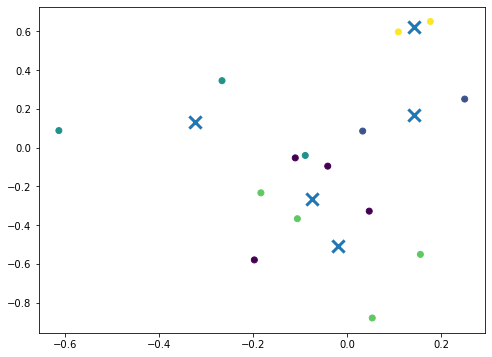

In [75]:
plt.figure(figsize=(8, 6))
plt.scatter(corpus_embeddings[:,0], corpus_embeddings[:,1], c=clustering_model.labels_.astype(float))
plt.scatter(centroids[:,0], centroids[:,1], marker = "x", s=150,linewidths = 3, zorder = 10)

In [76]:
from scipy.cluster.vq import vq

In [77]:
closest, distances = vq(centroids, corpus_embeddings)

In [78]:
closest

array([0, 5, 3, 8, 9])

In [79]:
for index in closest: 
    print(corpus[index])

A man is eating food.
A man is riding a horse.
The girl is carrying a baby.
Someone in a gorilla costume is playing a set of drums.
A cheetah is running behind its prey.


In [58]:
!pip show pytextrank

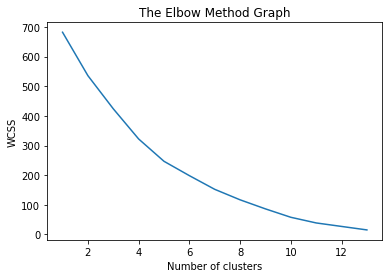

In [90]:
#3 Using the elbow method to find out the optimal number of #clusters. 
#KMeans class from the sklearn library.
from sklearn.cluster import KMeans
wcss=[]
#this loop will fit the k-means algorithm to our data and 
#second we will compute the within cluster sum of squares and #appended to our wcss list.
for i in range(1,14): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
    #i above is between 1-10 numbers. init parameter is the random #initialization method  
    #we select kmeans++ method. max_iter parameter the maximum number of iterations there can be to 
    #find the final clusters when the K-meands algorithm is running. we #enter the default value of 300
    #the next parameter is n_init which is the number of times the #K_means algorithm will be run with
    #different initial centroid.
    kmeans.fit(corpus_embeddings)
    #kmeans algorithm fits to the X dataset
    wcss.append(kmeans.inertia_)
    #kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center.
    
#4.Plot the elbow graph
plt.plot(range(1,14),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [91]:
wcss

[682.1005249023438,
 535.6195678710938,
 423.923095703125,
 322.1168518066406,
 246.7586669921875,
 198.3743438720703,
 152.21234130859375,
 116.83160400390625,
 86.23966217041016,
 57.906272888183594,
 38.8232421875,
 27.054317474365234,
 15.2972993850708]

# Fix Steam Crawler

Try to limit the number of crawled reviews.

In [92]:
import copy
import datetime
import json
import pathlib
import time

import requests

In [94]:
def get_steam_api_rate_limits():
    # Objective: return the rate limits of Steam API for reviews.

    rate_limits = {
        "max_num_queries": 150,
        "cooldown": (5 * 60) + 10,  # 5 minutes plus a cushion
        "cooldown_bad_gateway": 10,  # arbitrary value to tackle 502 Bad Gateway due to saturated servers (during sales)
    }

    return rate_limits

In [93]:
def get_steam_api_url():
    # Objective: return the url of Steam API for reviews.

    return "https://store.steampowered.com/appreviews/"

In [ ]:
def get_default_request_parameters(chosen_request_params=None):
    # Objective: return a dict of default paramters for a request to Steam API.
    #
    # References:
    #   https://partner.steamgames.com/doc/store/getreviews
    #   https://partner.steamgames.com/doc/store/localization#supported_languages
    #   https://gist.github.com/adambuczek/95906b0c899c5311daeac515f740bf33

    default_request_parameters = {
        "json": "1",
        "language": "all",  # API language code e.g. english or schinese
        "filter": "recent",  # To work with 'start_offset', 'filter' has to be set to either recent or updated, not all.
        "review_type": "all",  # e.g. positive or negative
        "purchase_type": "all",  # e.g. steam or non_steam_purchase
        "num_per_page": "100",  # default is 20, maximum is 100
    }

    if chosen_request_params is not None:
        for element in chosen_request_params:
            default_request_parameters[element] = chosen_request_params[element]

    return default_request_parameters

In [ ]:
def get_request(app_id, chosen_request_params=None):
    request = dict(get_default_request_parameters(chosen_request_params))
    request["appids"] = str(app_id)

    return request

In [ ]:

resp_data = requests.get(get_steam_api_url() + req_data["appids"], params=req_data)
status_code = resp_data.status_code

In [1]:
import flair
sentiment_model = flair.models.TextClassifier.load('sentiment-fast')

D:\Anaconda3\envs\steam_insider\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


2021-06-22 00:24:48,659 loading file C:\Users\HuyTran\.flair\models\sentiment-en-mix-ft-rnn.pt


MemoryError: 